<img src="https://julialang.org/assets/infra/logo.svg" alt="Julia" width="200" style="max-width:100%;">

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/alan-turing-institute/MLJ.jl/master?filepath=binder/MLJ_demo.ipynb)

## Lightning encounter with Julia programming language

###### Julia related content prepared by [@ablaom](https://github.com/ablaom)

Interacting with Julia at the REPL, or in a notebook, feels very much

the same as python, MATLAB or R:

In [1]:
print("Hello world!")

Hello world!

In [2]:
2 + 2

4

In [3]:
typeof(42.0)

Float64

## Just-in-time compilation

Here's a function used in generating the famous Mandelbrot set,

which looks pretty much the same in python, MATLAB or R:

In [4]:
function mandel(z)
    c = z
    maxiter = 80
    for n in 1:maxiter
        if abs(z) > 2
            return n-1
        end
        z = z^2 + c
    end
    return maxiter
end

mandel (generic function with 1 method)

In particular, notice the absence of type annotations. The crucial difference is what happens when you call this function:

In [5]:
@time mandel(1.2)  # time call on a Float64

  0.012019 seconds (29.06 k allocations: 1.662 MiB)


1

This is actually pretty lousy, slower than python. However, trying again:

In [6]:
@time mandel(3.4)   # time on another Float64

  0.000003 seconds (4 allocations: 160 bytes)


0

Thousands of times faster, second time around! What happenend?

When you call `mandel(1.2)` in python, say, then the defining code
is interpreted each time. When you call `mandel(1.2)` in Julia for
the first time Julia inspects the of the argument, namely `Float64`,
and using this information *compiles* an efficient type-specfic
version of `mandel`, which it caches for use in any subsequent call
*on the same type*. Indeed if we call `mandel` on a new type, a new
compilation will be needed:

In [7]:
@time mandel(1.0 + 5.0im)

  0.041186 seconds (75.59 k allocations: 4.152 MiB)


0

In [8]:
@time mandel(2.0 + 0.5im)

  0.000009 seconds (6 allocations: 224 bytes)


0

Since plotting the Mandelbrot set means calling `mandel` millions of
times on the same type, the advantage of just-in-time compilation is
obvious.

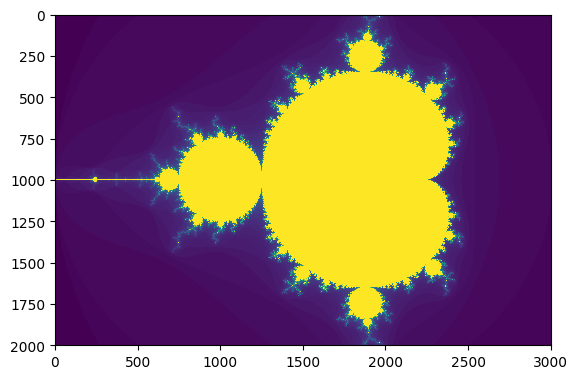

PyObject <matplotlib.image.AxesImage object at 0x7f9caf80f0b8>

In [9]:
using PyPlot

plt.imshow([mandel(x + y * im) for y = -1:0.001:1, x = -2:0.001:1])

## Multiple dispatch

You will never see anything like `A.add(B)` in Julia because Julia
is not a traditional object-oriented language. In Julia, function and
structure are kept separate, with the help of abstract types and
multiple dispatch, as we explain next
In addition to regular concrete types, such as `Float64` and
`String`, Julia has a built-in heirarchy of *abstract* types. These
generally have subtypes but no instances:

In [10]:
typeof(42)

Int64

In [11]:
supertype(Int64)

Signed

In [12]:
supertype(Signed)

Integer

In [13]:
subtypes(Integer)

3-element Array{Any,1}:
 Bool    
 Signed  
 Unsigned

In [14]:
Bool <: Integer # is Bool a subtype of Integer?

true

In [15]:
Bool <: String

false

In Julia, which is optionally typed, one uses type annotations to
adapt the behaviour of functions to their types. If we define

In [16]:
divide(x, y) = x / y

divide (generic function with 1 method)

then `divide(x, y)` will make sense whenever `x / y` makes sense (for
the built-in function `/`). For example, we can use it to divide two
integers, or two matrices:

In [17]:
divide(1, 2)

0.5

In [18]:
divide([1 2; 3 4], [1 2; 3 7])

2×2 Array{Float64,2}:
 1.0   0.0
 9.0  -2.0

To vary the behaviour for specific types we make type annotatations:

In [19]:
divide(x::Integer, y::Integer) = floor(x/y)
divide(x::String, y::String) = join([x, y], " / ")
divide(1, 2)

0.0

In [20]:
divide("Hello", "World!")

"Hello / World!"

In the case of `Float64` the original "fallback" method still
applies:

In [21]:
divide(1.0, 2.0)

0.5

## User-defined types

Users can define their own abstract types and composite types:

In [22]:
abstract type Organism end

struct Animal <: Organism
    name::String
    is_hervibore::Bool
end

struct Plant <: Organism
    name::String
    is_flowering::Bool
end

describe(o::Organism) = string(o.name) # fall-back method
function describe(p::Plant)

    if p.is_flowering
        text = " is a flowering plant."
    else
        text = " is a non-flowering plant."
    end
    return  p.name*text

end

describe (generic function with 2 methods)

In [23]:
describe(Animal("Elephant", true))

"Elephant"

In [24]:
describe(Plant("Fern", false))

"Fern is a non-flowering plant."

## Type inference and multiple dispatch

*Type inference* is the process of identifying the types of the arguments to dispatch the right method.

Blogpost about [type dispatch](http://www.stochasticlifestyle.com/type-dispatch-design-post-object-oriented-programming-julia/) by [Christopher Rackauckas](http://www.chrisrackauckas.com/).

In [25]:
function function_x(x::String)
    println("this is a string: $x")
end

function function_x(x::Int)
    println("$(x^2) is the square of $x")
end

function_x (generic function with 2 methods)

In [26]:
# each call to the function_x() will dispatch the corresponding method depending on the parameter's type
function_x("a string")
function_x(2)

this is a string: a string
4 is the square of 2


## Automatic differentiation

Differentiation of almost arbitrary programs with respect to their input. ([source]( https://render.githubusercontent.com/view/ipynb?commit=89317894e2e5370a80e45d52db8a4055a4fdecd6&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f6d6174626573616e636f6e2f454d455f4a756c69615f776f726b73686f702f383933313738393465326535333730613830653435643532646238613430353561346664656364362f315f496e74726f64756374696f6e2e6970796e62&nwo=matbesancon%2FEME_Julia_workshop&path=1_Introduction.ipynb&repository_id=270611906&repository_type=Repository#Automatic-differentiation) by [@matbesancon](https://github.com/matbesancon))

In [27]:
using ForwardDiff

function sqrt_babylonian(s)
    x = s / 2
    while abs(x^2 - s) > 0.001
        x = (x + s/x) / 2
    end
    x
end

sqrt_babylonian (generic function with 1 method)

In [28]:
sqrt_babylonian(2) - sqrt(2)

2.123901414519125e-6

In [29]:
@show ForwardDiff.derivative(sqrt_babylonian, 2);
@show ForwardDiff.derivative(sqrt, 2);

ForwardDiff.derivative(sqrt_babylonian, 2) = 0.353541906958862
ForwardDiff.derivative(sqrt, 2) = 0.35355339059327373


## Unitful computations
Physicists' dreams finally made true. ([soure](https://render.githubusercontent.com/view/ipynb?commit=89317894e2e5370a80e45d52db8a4055a4fdecd6&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f6d6174626573616e636f6e2f454d455f4a756c69615f776f726b73686f702f383933313738393465326535333730613830653435643532646238613430353561346664656364362f315f496e74726f64756374696f6e2e6970796e62&nwo=matbesancon%2FEME_Julia_workshop&path=1_Introduction.ipynb&repository_id=270611906&repository_type=Repository#Unitful-computations) by [@matbesancon](https://github.com/matbesancon))

In [30]:
using Unitful
using Unitful: J, kg, m, s

In [31]:
3J + 1kg * (1m / 1s)^2

4.0 kg m² s⁻²

<img src="https://github.com/alan-turing-institute/MLJ.jl/raw/master/material/MLJLogo2.svg?sanitize=true" alt="MLJ" width="200" style="max-width:100%;">

# MLJ

MLJ (Machine Learning in Julia) is a toolbox written in Julia providing a common interface and meta-algorithms for selecting, tuning, evaluating, composing and comparing machine learning models written in Julia and other languages. MLJ is released under the MIT licensed and sponsored by the [Alan Turing Institute](https://www.turing.ac.uk/).

### The MLJ Universe

The functionality of MLJ is distributed over a number of repositories
illustrated in the dependency chart below.

[MLJ](https://github.com/alan-turing-institute/MLJ) * [MLJBase](https://github.com/alan-turing-institute/MLJBase.jl) * [MLJModelInterface](https://github.com/alan-turing-institute/MLJModelInterface.jl) * [MLJModels](https://github.com/alan-turing-institute/MLJModels.jl) * [MLJTuning](https://github.com/alan-turing-institute/MLJTuning.jl) * [MLJLinearModels](https://github.com/alan-turing-institute/MLJLinearModels.jl) * [MLJFlux](https://github.com/alan-turing-institute/MLJFlux.jl) * [MLJTutorials](https://github.com/alan-turing-institute/MLJTutorials) * [MLJScientificTypes](https://github.com/alan-turing-institute/MLJScientificTypes.jl) * [ScientificTypes](https://github.com/alan-turing-institute/ScientificTypes.jl)


<div align="center">
    <img src="https://github.com/alan-turing-institute/MLJ.jl/raw/master/material/MLJ_stack.svg?sanitize=true" alt="Dependency Chart">
</div>

*Dependency chart for MLJ repositories. Repositories with dashed
connections do not currently exist but are planned/proposed.*

MLJ provides access to to a wide variety of machine learning models. For the most up-to-date list of available models `models()`.

In [32]:
using MLJ
models()

┌ Info: Recompiling stale cache file /Users/darenasc/.julia/compiled/v1.2/MLJ/rAU56.ji for MLJ [add582a8-e3ab-11e8-2d5e-e98b27df1bc7]
└ @ Base loading.jl:1240


132-element Array{NamedTuple{(:name, :package_name, :is_supervised, :docstring, :hyperparameter_ranges, :hyperparameter_types, :hyperparameters, :implemented_methods, :is_pure_julia, :is_wrapper, :load_path, :package_license, :package_url, :package_uuid, :prediction_type, :supports_online, :supports_weights, :input_scitype, :target_scitype, :output_scitype),T} where T<:Tuple,1}:
 (name = ARDRegressor, package_name = ScikitLearn, ... )             
 (name = AdaBoostClassifier, package_name = ScikitLearn, ... )       
 (name = AdaBoostRegressor, package_name = ScikitLearn, ... )        
 (name = AdaBoostStumpClassifier, package_name = DecisionTree, ... ) 
 (name = AffinityPropagation, package_name = ScikitLearn, ... )      
 (name = AgglomerativeClustering, package_name = ScikitLearn, ... )  
 (name = BaggingClassifier, package_name = ScikitLearn, ... )        
 (name = BaggingRegressor, package_name = ScikitLearn, ... )         
 (name = BayesianLDA, package_name = MultivariateStats, ..

## Fit, predict, transform

The following example is using the `fit()`, `predict()`, and `transform()` functions of MLJ.

In [33]:
import Statistics
using PrettyPrinting
using StableRNGs

In [34]:
X, y = @load_iris;

let's also load the DecisionTreeClassifier:

In [35]:
@load DecisionTreeClassifier
tree_model = DecisionTreeClassifier()

DecisionTreeClassifier(
    max_depth = -1,
    min_samples_leaf = 1,
    min_samples_split = 2,
    min_purity_increase = 0.0,
    n_subfeatures = 0,
    post_prune = false,
    merge_purity_threshold = 1.0,
    pdf_smoothing = 0.0,
    display_depth = 5) @ 1…27

## MLJ Machine

In MLJ, a *model* is an object that only serves as a container for the hyperparameters of the model. A *machine* is an object wrapping both a model and data and can contain information on the *trained* model; it does *not* fit the model by itself. However, it does check that the model is compatible with the scientific type of the data and will warn you otherwise.

In [36]:
tree = machine(tree_model, X, y)

Machine{DecisionTreeClassifier} @ 1…24


A machine is used both for supervised and unsupervised model. In this tutorial we give an example for the supervised model first and then go on with the unsupervised case.

## Training and testing a supervised model

Now that you've declared the model you'd like to consider and the data, we are left with the standard training and testing step for a supervised learning algorithm.

## Splitting the data

To split the data into a training and testing set, you can use the function `partition` to obtain indices for data points that should be considered either as training or testing data:

In [37]:
rng = StableRNG(566)
train, test = partition(eachindex(y), 0.7, shuffle=true, rng=rng)
test[1:3]

3-element Array{Int64,1}:
 39
 54
  9

## Fitting and testing the machine

To fit the machine, you can use the function `fit!` specifying the rows to be used for the training:

In [38]:
fit!(tree, rows=train)

┌ Info: Training Machine{DecisionTreeClassifier} @ 1…24.
└ @ MLJBase /Users/darenasc/.julia/packages/MLJBase/Cb9AY/src/machines.jl:187


Machine{DecisionTreeClassifier} @ 1…24


Note that this **modifies** the machine which now contains the trained parameters of the decision tree. You can inspect the result of the fitting with the `fitted_params` method:

In [39]:
fitted_params(tree) |> pprint

(tree = Decision Tree
Leaves: 5
Depth:  4,
 encoding = Dict("virginica" => 0x00000003,
                 "setosa" => 0x00000001,
                 "versicolor" => 0x00000002))

This `fitresult` will vary from model to model though classifiers will usually give out a tuple with the first element corresponding to the fitting and the second one keeping track of how classes are named (so that predictions can be appropriately named).

You can now use the machine to make predictions with the `predict` function specifying rows to be used for the prediction:

In [40]:
ŷ = predict(tree, rows=test)
@show ŷ[1]

ŷ[1] = UnivariateFinite{Multiclass{3}}(setosa=>1.0, versicolor=>0.0, virginica=>0.0)


UnivariateFinite{Multiclass{3}}(setosa=>1.0, versicolor=>0.0, virginica=>0.0)

Note that the output is probabilistic, effectively a vector with a score for each class. You could get the mode by using the `mode` function on `ŷ` or using `predict_mode`:

In [41]:
ȳ = predict_mode(tree, rows=test)
@show ȳ[1]
@show mode(ŷ[1])

ȳ[1] = "setosa"
mode(ŷ[1]) = "setosa"


CategoricalArrays.CategoricalValue{String,UInt32} "setosa"

To measure the discrepancy between ŷ and y you could use the average cross entropy:

In [42]:
mce = cross_entropy(ŷ, y[test]) |> mean
round(mce, digits=4)

2.4029

# [Check out MLJ example with TreeParzen.jl](TreeParzen_example.ipynb)

# A more advanced example

In [43]:
using MLJ
using StableRNGs
import DataFrames
@load RidgeRegressor pkg=MultivariateStats

┌ Info: Recompiling stale cache file /Users/darenasc/.julia/compiled/v1.2/MultivariateStats/l7I74.ji for MultivariateStats [6f286f6a-111f-5878-ab1e-185364afe411]
└ @ Base loading.jl:1240


RidgeRegressor(
    lambda = 1.0) @ 1…26

In this example we will show how to generate a model from a network; there are two approaches:

* using the `@from_network` macro
* writing the model in full

the first approach should usually be the one considered as it's simpler.

Generating a model from a network allows subsequent composition of that network with other tasks and tuning of that network.

### Using the @from_network macro

Let's define a simple network

*Input layer*

In [44]:
rng = StableRNG(6616) # for reproducibility
x1 = rand(rng, 300)
x2 = rand(rng, 300)
x3 = rand(rng, 300)
y = exp.(x1 - x2 -2x3 + 0.1*rand(rng, 300))
X = DataFrames.DataFrame(x1=x1, x2=x2, x3=x3)
test, train = partition(eachindex(y), 0.8);

Xs = source(X)
ys = source(y, kind=:target)

Source{:target} @ 1…62


*First layer*

In [45]:
std_model = Standardizer()
stand = machine(std_model, Xs)
W = MLJ.transform(stand, Xs)

box_model = UnivariateBoxCoxTransformer()
box = machine(box_model, ys)
z = MLJ.transform(box, ys)

Node @ 5…77 = transform(5…00, 1…62)

*Second layer*

In [46]:
ridge_model = RidgeRegressor(lambda=0.1)
ridge = machine(ridge_model, W, z)
ẑ = predict(ridge, W)

Node @ 1…44 = predict(4…03, transform(7…37, 6…82))

*Output*

In [47]:
ŷ = inverse_transform(box, ẑ)

Node @ 2…37 = inverse_transform(5…00, predict(4…03, transform(7…37, 6…82)))

No fitting has been done thus far, we have just defined a sequence of operations.

To form a model out of that network is easy using the `@from_network` macro:

In [48]:
@from_network CompositeModel(std=std_model, box=box_model,
                             ridge=ridge_model) <= ŷ;

The macro defines a constructor CompositeModel and attributes a name to the different models; the ordering / connection between the nodes is inferred from `ŷ` via the `<= ŷ`.

**Note**: had the model been probabilistic (e.g. `RidgeClassifier`) you would have needed to add `is_probabilistic=true` at the end.

In [49]:
cm = machine(CompositeModel(), X, y)
res = evaluate!(cm, resampling=Holdout(fraction_train=0.8, rng=51),
                measure=rms)
round(res.measurement[1], sigdigits=3)

0.0136

## Check out more [Data Science tutorials in Julia](https://alan-turing-institute.github.io/DataScienceTutorials.jl/).